In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
import scipy.sparse
import scipy.sparse.linalg
import random
import sys

In [2]:
k =10#int(input())
a = 0#int(input())
b = 1#int(input())
variance = 0.4#float(input())
N = 5

In [3]:
Theta_true = np.ones((k,1))
X = np.linspace(a,b, N)

In [4]:
def vandermonde(X, K):
    rows = []
    for i in range(np.size(X)):
        row = [X[i] ** k for k in range(K)]
        rows.append(row)
    return np.array(rows)

In [5]:
v = vandermonde(X, k)
e = np.random.normal(0,variance)
Y = v @ Theta_true + e

In [32]:
def gradient(f, grad_f, x0, KMAX, tolf, tolx, alpha = 1e-3):
    i = 0
    x_k = x0
    x_kOld = x0
    grad_0 = np.linalg.norm(grad_f(x0), 2)
    while True:
        x_kOld = x_k
        x_k = x_kOld - alpha * grad_f(x_kOld)

        grad_val =  grad_f(x_k)
        err_val = np.linalg.norm(grad_val, 2)


        if i > KMAX or err_val < tolf * grad_0 or np.linalg.norm(x_k - x_kOld, 2) < tolx:
            return x_k
        i +=1

def SGD(l, grad_l, w0, data, batch_size, n_epoch, alpha = 1):
    x, y = data
    N = np.size(x)
    epoch_iter = int(N / batch_size)
    x_copy = np.copy(x)
    y_copy = np.copy(y)
    W_hat = w0
    for epoch in range(n_epoch):
        for k in range(epoch_iter):
            # print(f'epoch: {epoch}, k: {k}')
            indexes = np.arange(np.size(x))
            batch_idx = np.random.choice(indexes, batch_size)
            
            mask = np.zeros((np.size(x), ), dtype=bool)
            mask[batch_idx] = True
            x_batch = x[mask]
            y_batch = y[mask]
            
            x = x[~ mask]
            y = y[~ mask]
            grad_value = grad_l((W_hat, x_batch, y_batch))
            W_hat = W_hat - alpha * grad_value
        
        x = np.copy(x_copy) 
        y = np.copy(y_copy)
    
    return W_hat

In [60]:
def MLE(D, k, algorithm = "n"):
    X, Y = D
    phi = vandermonde(X, k)
    if algorithm == "n":
        return np.linalg.solve(phi.T @ phi, phi.T @ Y)
    if algorithm == "g":
        f = lambda theta: 1/2 * np.linalg.norm(phi @ theta - Y,2) ** 2 
        grad_f = lambda theta : phi.T @ ((phi @ theta) - Y)
        return gradient(f, grad_f, np.zeros((k,)), 600, sys.float_info.min, sys.float_info.min)
    if algorithm == "sgd":
        def f(data):
            theta, x, y = data
            _phi = vandermonde(x,k)
            return 1/2 * np.linalg.norm(_phi @ theta - y,2) ** 2 
        def grad_f(data):
            theta, x, y = data
            _phi = vandermonde(x,k)
            return _phi.T @ ((_phi @ theta) - y)
        return SGD(f, grad_f, np.zeros((k,)), (X,Y), 100, 10)

def MAP(D, k, l, algorithm = "n"):
    X, Y = D
    phi = vandermonde(X, k)
    if algorithm == "n":
        return np.linalg.inv(phi.T @ phi + l * np.identity(k)) @ phi.T @ Y
    if algorithm == "g":
        f = lambda theta: 1/2 * np.linalg.norm(phi @ theta - Y,2) ** 2 + l/2 * np.linalg.norm(theta, 2) ** 2
        grad_f = lambda theta:  phi.T @ ((phi @ theta) - Y) + (l * theta)
        return gradient(f, grad_f, np.zeros((k,)), 600, sys.float_info.min, sys.float_info.min)
    if algorithm == "sgd":
        def f(data):
            theta, x, y = data
            _phi = vandermonde(x,k)
            return 1/2 * np.linalg.norm(_phi @ theta - y,2) ** 2 + l/2 * np.linalg.norm(theta, 2) ** 2
        def grad_f(data):
            theta, x, y = data
            _phi = vandermonde(x,k)
            return _phi.T @ ((_phi @ theta) - y) + (l * theta)
        return SGD(f, grad_f, np.zeros((k,)), (X,Y), 100, 10, 1e-3)

def f(theta, X):
    return X @ theta

def accuracy(theta, Dtest):
    X, Y = Dtest
    N = np.size(Y)
    f_value = f(theta, X)
    return 1/N * np.linalg.norm(f_value - Y, 2)**2

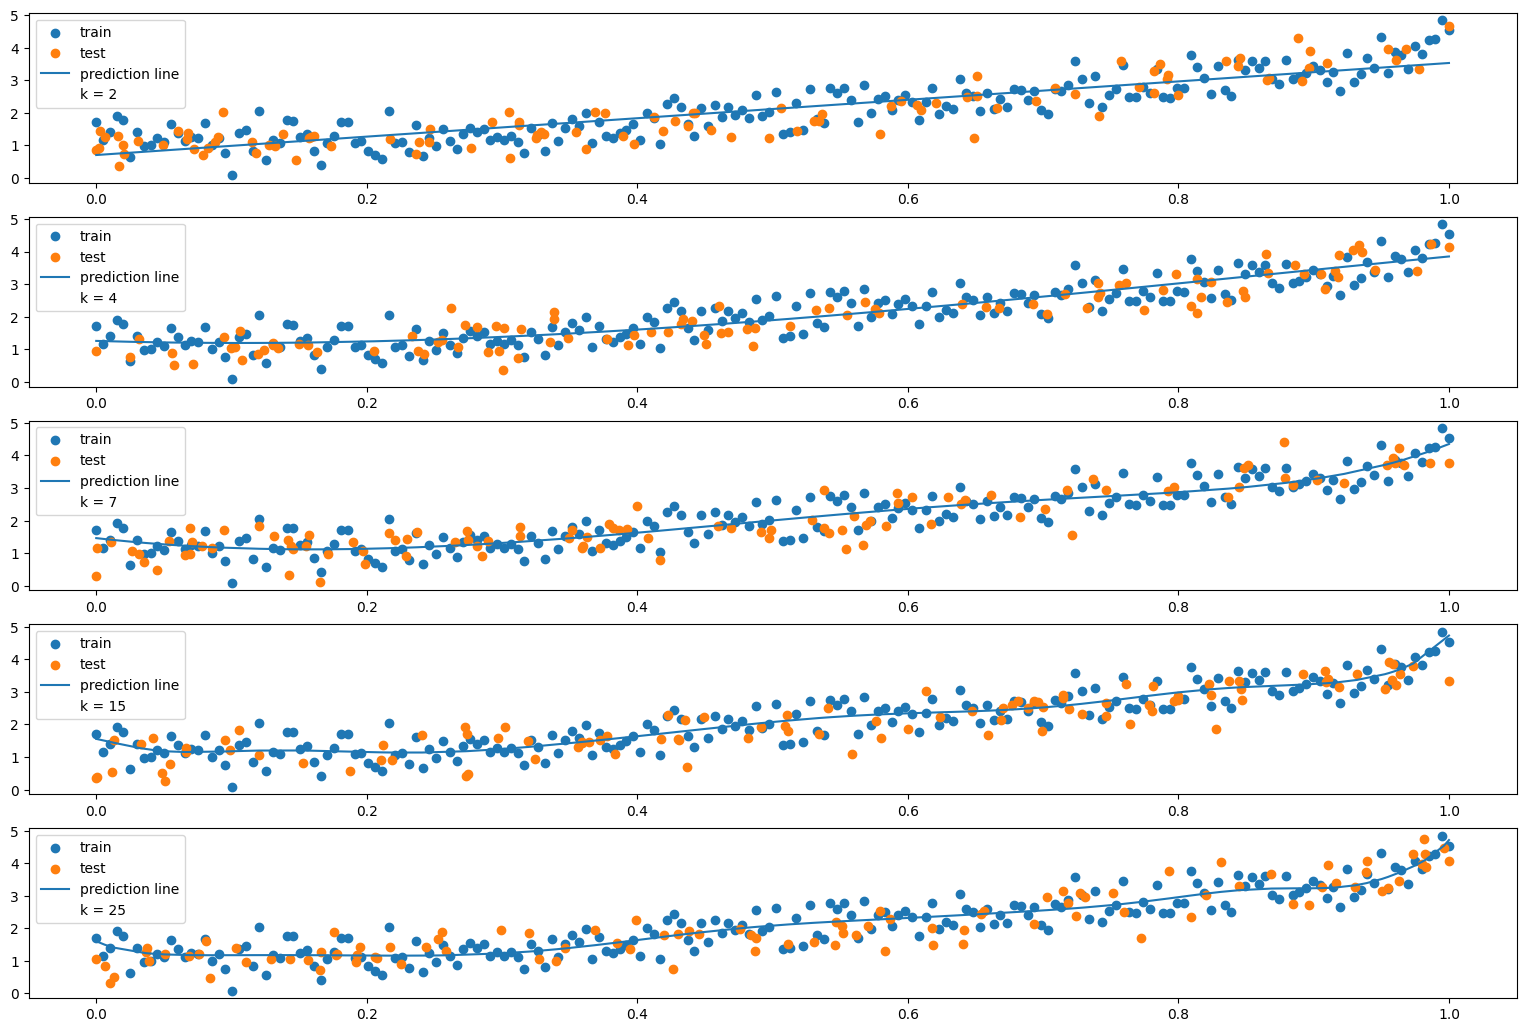

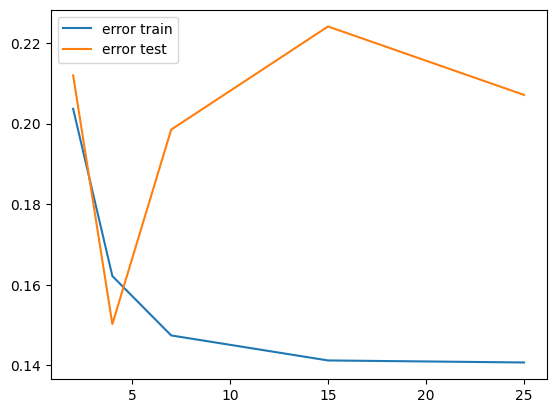

In [8]:
np.random.seed(0)
k_original = 4
N = 200
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
e = np.random.normal(0,variance, (N,1))
Y = (v @ Theta_true) 
Y += e
acc_test = []
acc_train = []
ks = []
fig, axs = plt.subplots(5, figsize=(19.2,12.8))
j = 0
for k in [2,k_original, 7, 15, 25]:
    mle = MLE((X, Y), k)

    Xtest = np.random.default_rng().uniform(a, b, int(N/2))
    Xtest.sort()
    Xtest = np.concatenate(([a],Xtest, [b])) 
    vtest = vandermonde(Xtest, k_original)
    etest = np.random.normal(0,variance, (int(N/2) + 2,1))
    Ytest = (vtest @ np.ones((k_original,1))) + etest

    axs[j].scatter(X, Y, label = "train")
    axs[j].scatter(Xtest, Ytest, label = "test")
    f_value = f(mle, vandermonde(Xtest,k))
    acc_test.append(accuracy(mle, (vandermonde(Xtest, k), Ytest)))
    acc_train.append(accuracy(mle, (vandermonde(X, k), Y)))
    ks.append(k)
    axs[j].plot(Xtest, f_value, label = "prediction line")
    axs[j].plot([], [], ' ', label=f"k = {k}")
    axs[j].legend()
    j +=1
plt.show()

plt.plot(ks,acc_train, label = "error train")
plt.plot(ks,acc_test, label = "error test")
plt.legend()
plt.show()


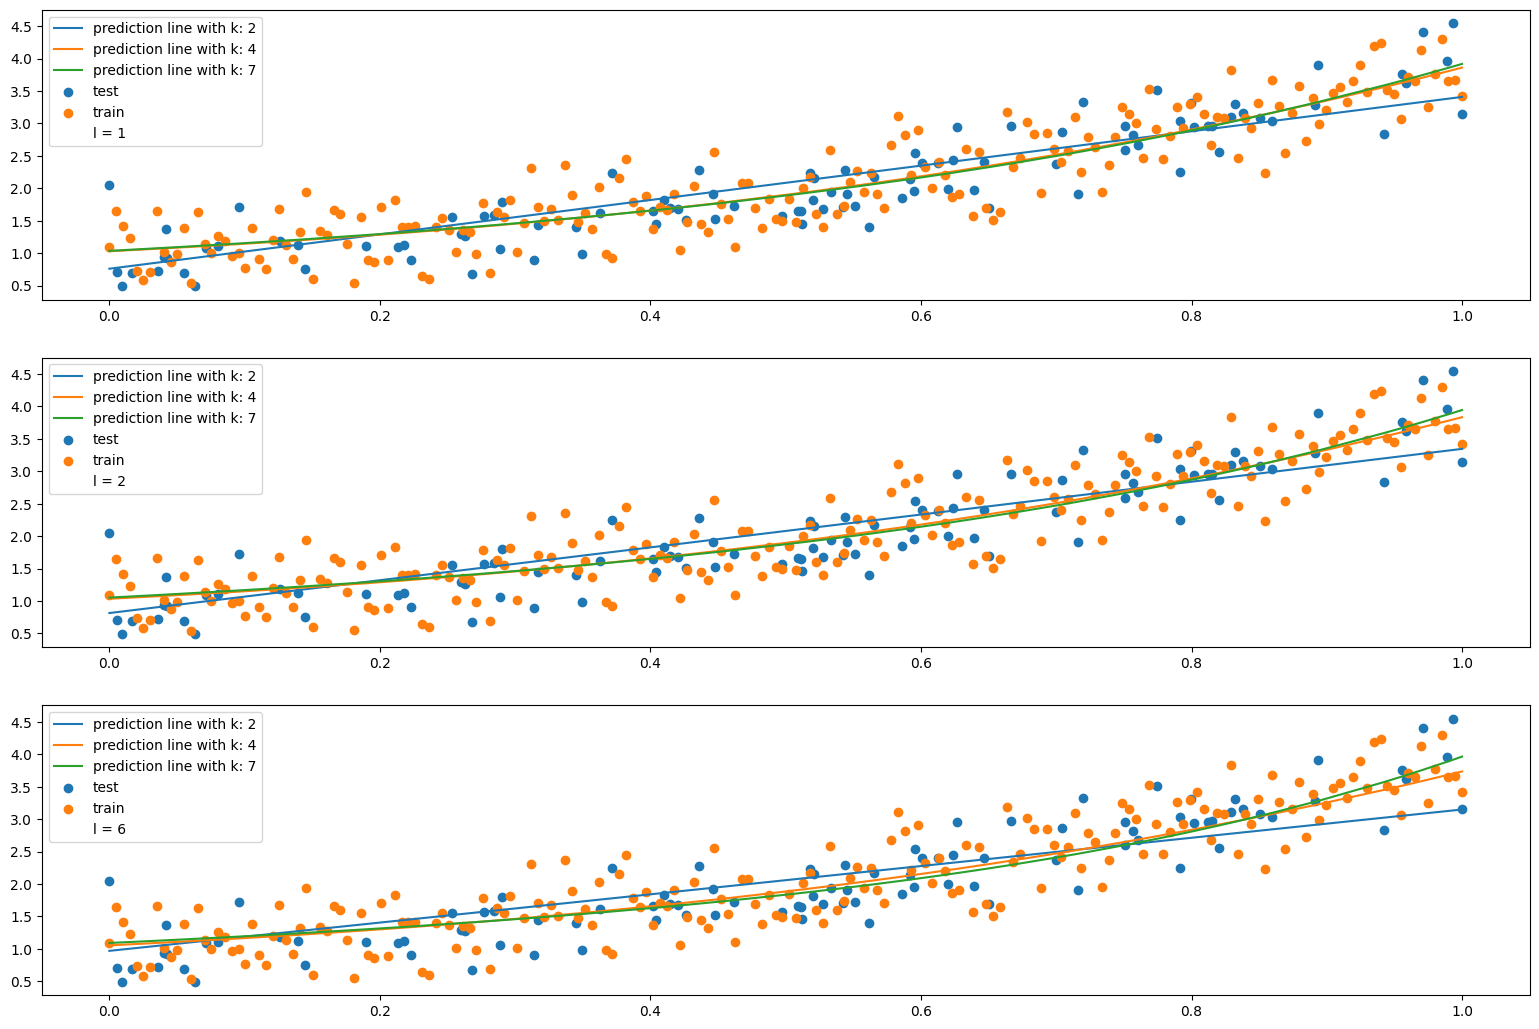

In [15]:
k_original = 4
N = 200
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
e = np.random.normal(0,variance, (N,1))
Y = (v @ Theta_true) 
Y += e

Xtest = np.random.default_rng().uniform(a, b, int(N/2))
Xtest.sort()
Xtest = np.concatenate(([a],Xtest, [b])) 
vtest = vandermonde(Xtest, k_original)
etest = np.random.normal(0,variance, (int(N/2) + 2,1))
Ytest = (vtest @ np.ones((k_original,1))) + etest

fig, axs = plt.subplots(3, figsize=(19.2,12.8))
j = 0
for l in [1,2,6]:
    for k_map in [2,k_original,7]:
        map = MAP((X,Y), k_map, l)
        f_value = f(map, vandermonde(Xtest,k_map))
        axs[j].plot(Xtest, f_value, label = f"prediction line with k: {k_map}")
    axs[j].scatter(Xtest, Ytest, label = "test")
    axs[j].scatter(X, Y, label = "train")
    axs[j].plot([], [], ' ', label=f"l = {l}")
    axs[j].legend()
    j += 1
plt.show()

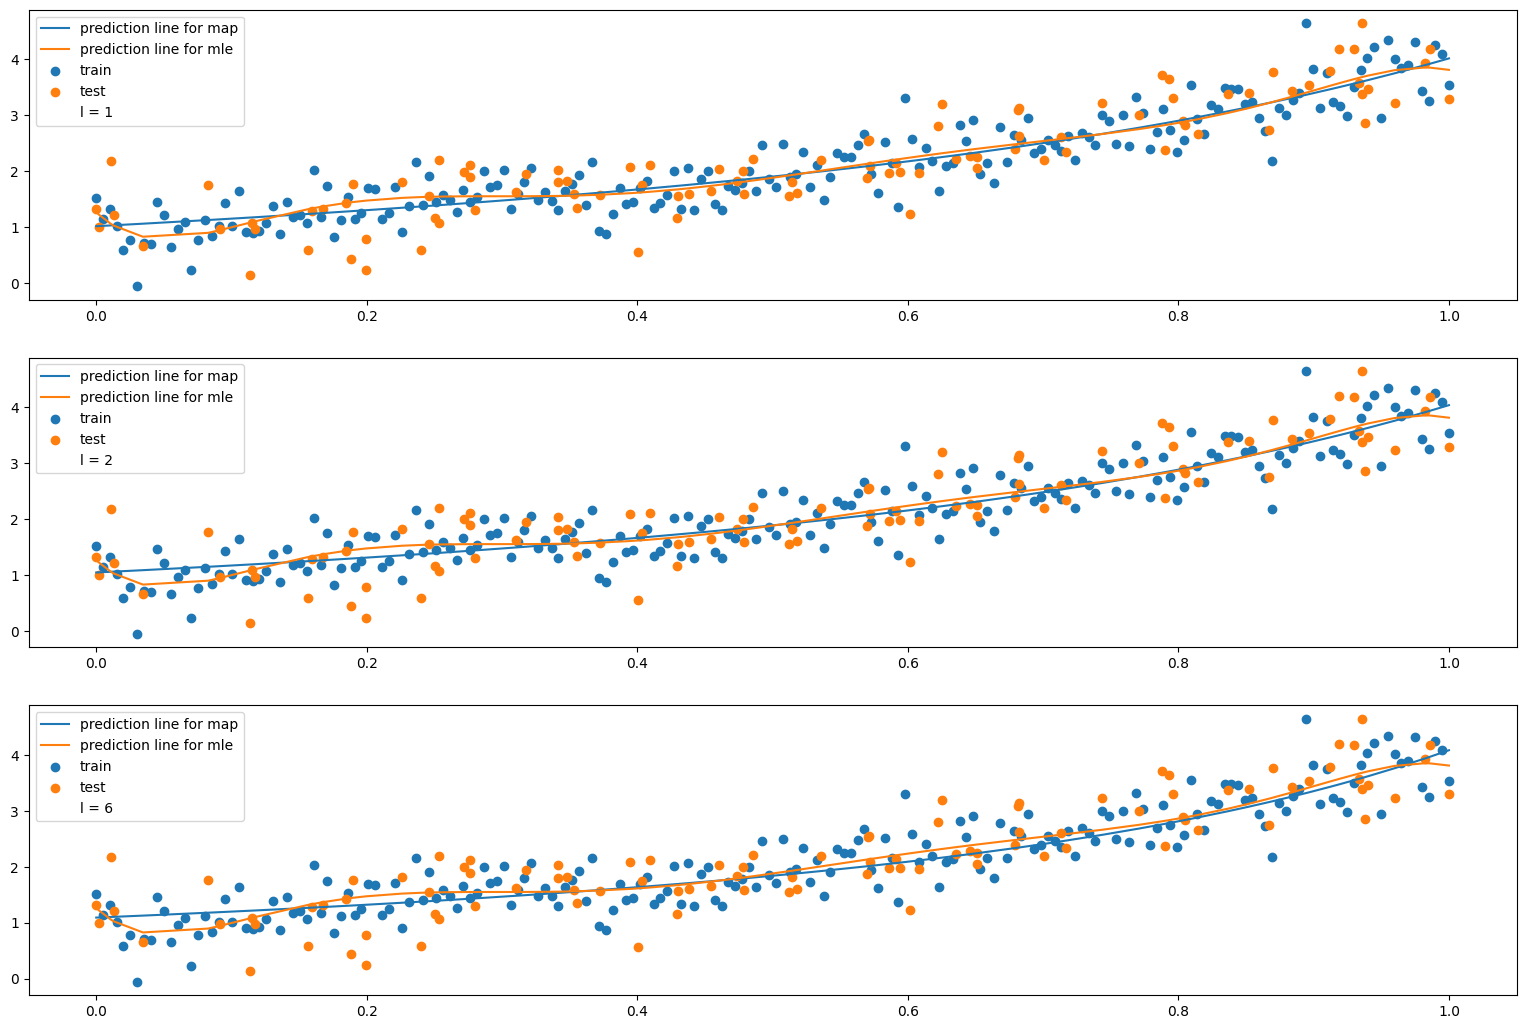

In [52]:
k_original = 4
N = 200
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
e = np.random.normal(0,variance, (N,1))
Y = (v @ Theta_true) 
Y += e

Xtest = np.random.default_rng().uniform(a, b, int(N/2))
Xtest.sort()
Xtest = np.concatenate(([a],Xtest, [b])) 
vtest = vandermonde(Xtest, k_original)
etest = np.random.normal(0,variance, (int(N/2) + 2,1))
Ytest = (vtest @ np.ones((k_original,1))) + etest

k_all = 10
mle = MLE((X, Y), k_all)
f_value_mle = f(mle, vandermonde(Xtest,k_all))
fig, axs = plt.subplots(3, figsize=(19.2,12.8))
j = 0
for l in [1,2,6]:
    map = MAP((X,Y), k_all, l)
    f_value_map = f(map, vandermonde(Xtest,k_all))
    axs[j].plot(Xtest, f_value_map, label = f"prediction line for map")
    axs[j].plot(Xtest, f_value_mle, label = f"prediction line for mle")
    axs[j].scatter(X, Y, label = "train")
    axs[j].scatter(Xtest, Ytest, label = "test")
    axs[j].plot([], [], ' ', label=f"l = {l}")
    axs[j].legend()
    j += 1
plt.show()

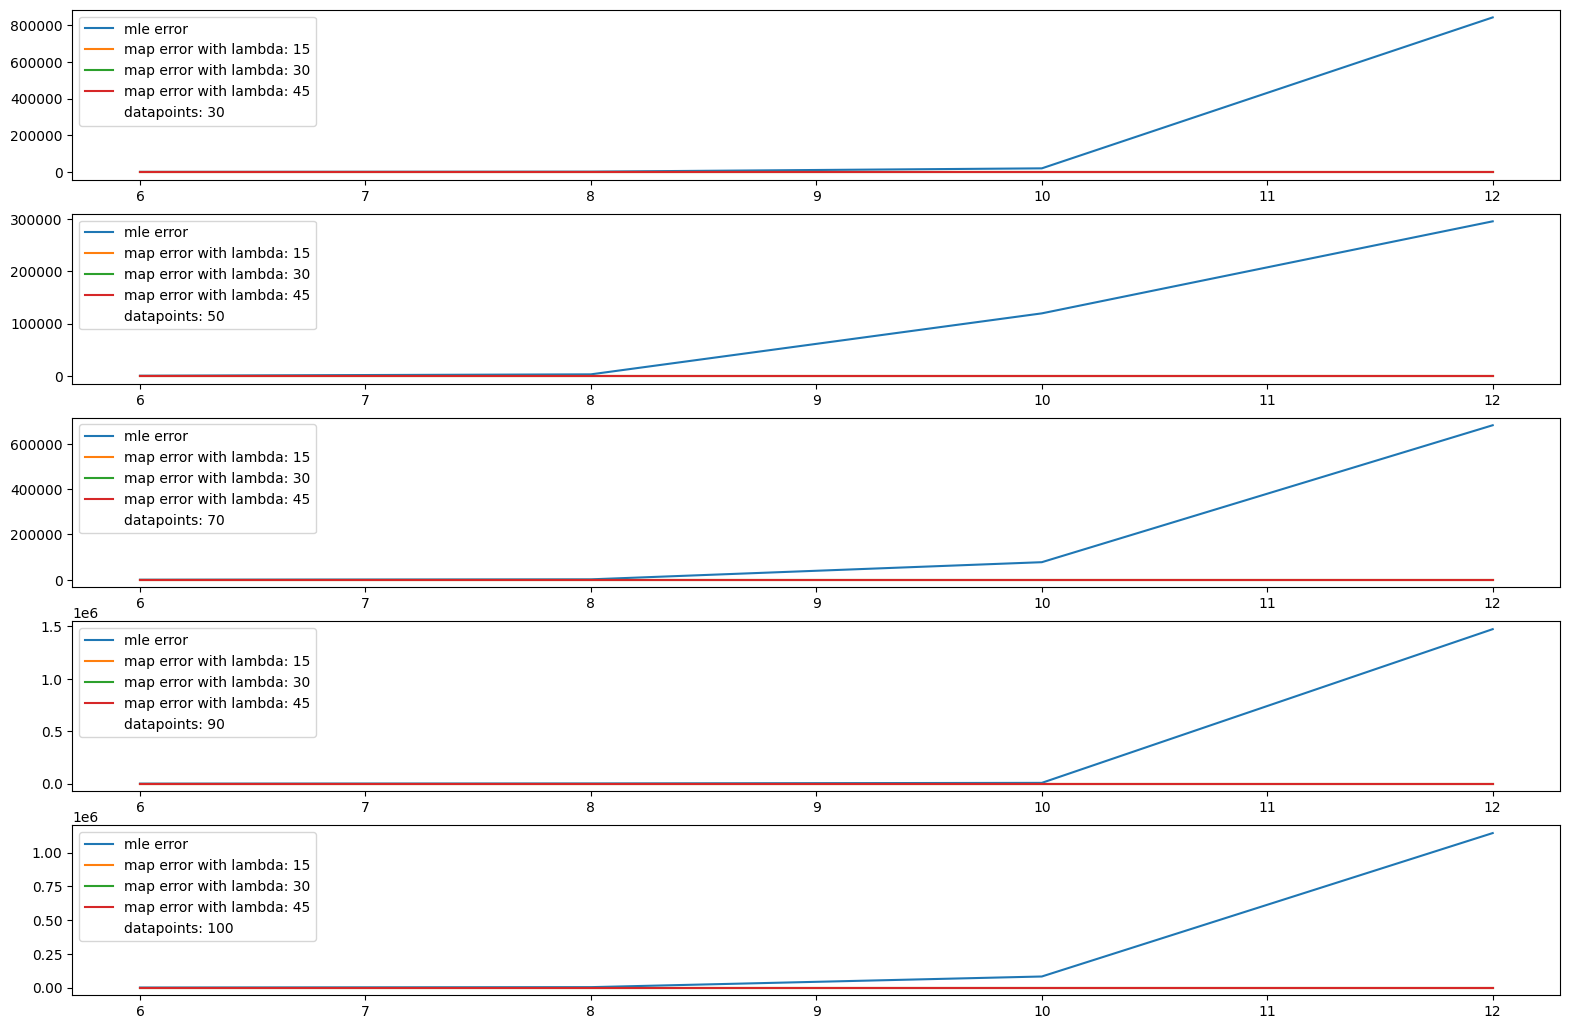

In [74]:
fig, axs = plt.subplots(5, figsize=(19.2,12.8))
j = 0
for N in [30, 50, 70, 90, 100]:
    k_original = 4
    Theta_true = np.ones((k_original,1))
    variance_original = 0.4
    variance = variance_original
    X = np.linspace(a,b, N)
    v = vandermonde(X, k_original)
    e = np.random.normal(0,variance, (N,1))
    Y = (v @ Theta_true) 
    Y += e

    Xtest = np.random.default_rng().uniform(a, b, int(N/2))
    Xtest.sort()
    Xtest = np.concatenate(([a],Xtest, [b])) 
    vtest = vandermonde(Xtest, k_original)
    etest = np.random.normal(0,variance, (int(N/2) + 2,1))
    Ytest = (vtest @ np.ones((k_original,1))) + etest

    def errorCompute(theta, theta_true):
        return np.linalg.norm(theta - theta_true, 2) / np.linalg.norm(theta_true, 2)

    mle_err = []
    map_err = {15: [], 30: [], 45: []}
    for k_all in [6,8,10,12]:
        theta_true_k = np.concatenate((Theta_true, np.zeros((k_all - k_original, 1))))
        mle = MLE((X, Y), k_all)
        error_mle = errorCompute(mle, theta_true_k)
        mle_err.append(error_mle)
        for l in [15, 30, 45]:
            map = MAP((X,Y), k_all, l)
            error_map = errorCompute(map, theta_true_k)
            map_err[l].append(error_map)

    axs[j].plot([6,8,10,12],mle_err, label = f"mle error")
    for el in map_err:
        axs[j].plot([6,8,10,12],map_err[el], label = f"map error with lambda: {el}")
    axs[j].plot([], [], ' ', label=f"datapoints: {N}")
    axs[j].legend()
    j += 1
plt.show()

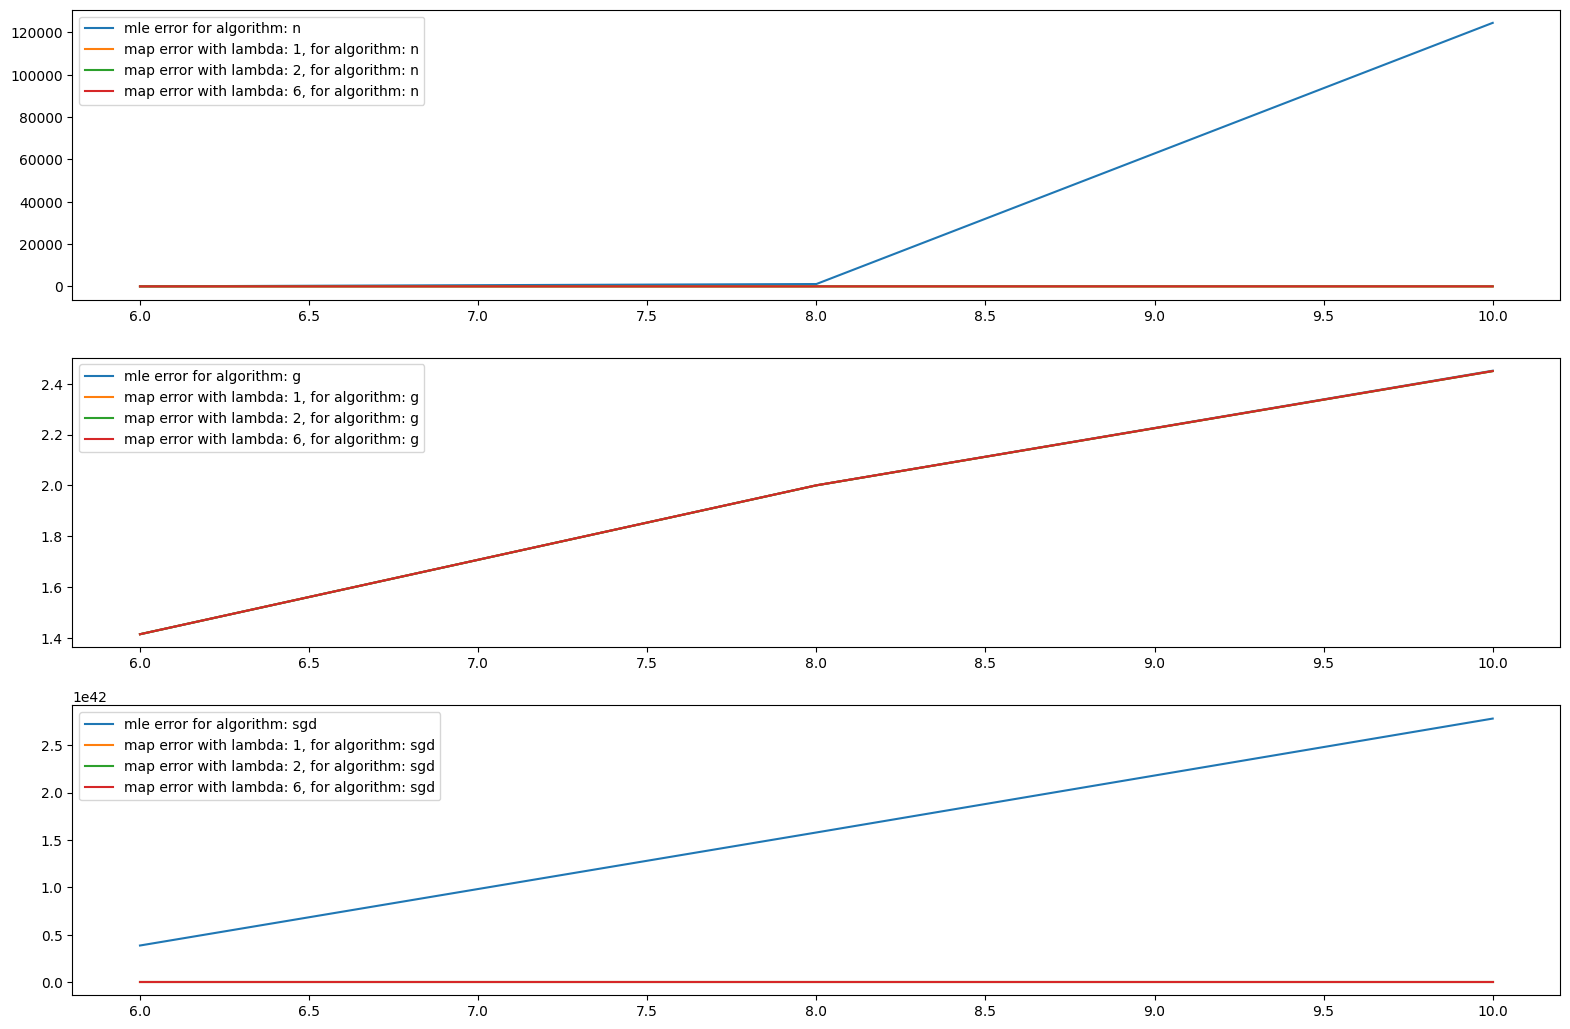

In [73]:
N = 200
k_original = 4
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
e = np.random.normal(0,variance, (N,1))
Y = (v @ Theta_true) 
Y += e
Y = np.reshape(Y, (N,))
Xtest = np.random.default_rng().uniform(a, b, int(N/2))
Xtest.sort()
Xtest = np.concatenate(([a],Xtest, [b])) 
vtest = vandermonde(Xtest, k_original)
etest = np.random.normal(0,variance, (int(N/2) + 2,1))
Ytest = (vtest @ np.ones((k_original,))) + etest
def errorCompute(theta, theta_true):
    return np.linalg.norm(theta - theta_true, 2) / np.linalg.norm(theta_true, 2)

mle_err = {"n": [], "g": [], "sgd": []}
map_err = {"n": {1: [], 2: [], 6: []}, "g": {1: [], 2: [], 6: []}, "sgd": {1: [], 2: [], 6: []}}
fig, axs = plt.subplots(3, figsize=(19.2,12.8))
j = 0
for alg in ["n", "g", "sgd"]:
    for k_all in [6,8,10]:
        theta_true_k = np.concatenate((Theta_true, np.zeros((k_all - k_original,1))))
        mle = MLE((X, Y), k_all, alg)
        error_mle = errorCompute(mle, theta_true_k)
        mle_err[alg].append(error_mle)
        for l in [1,2,6]:
            map = MAP((X,Y), k_all, l, alg)
            error_map = errorCompute(map, theta_true_k)
            map_err[alg][l].append(error_map)
    axs[j].plot([6,8,10], mle_err[alg], label = f"mle error for algorithm: {alg}")
    for l in [1,2,6]:
        axs[j].plot([6,8,10], map_err[alg][l], label = f"map error with lambda: {l}, for algorithm: {alg}")
    axs[j].legend()

    j += 1
plt.show()

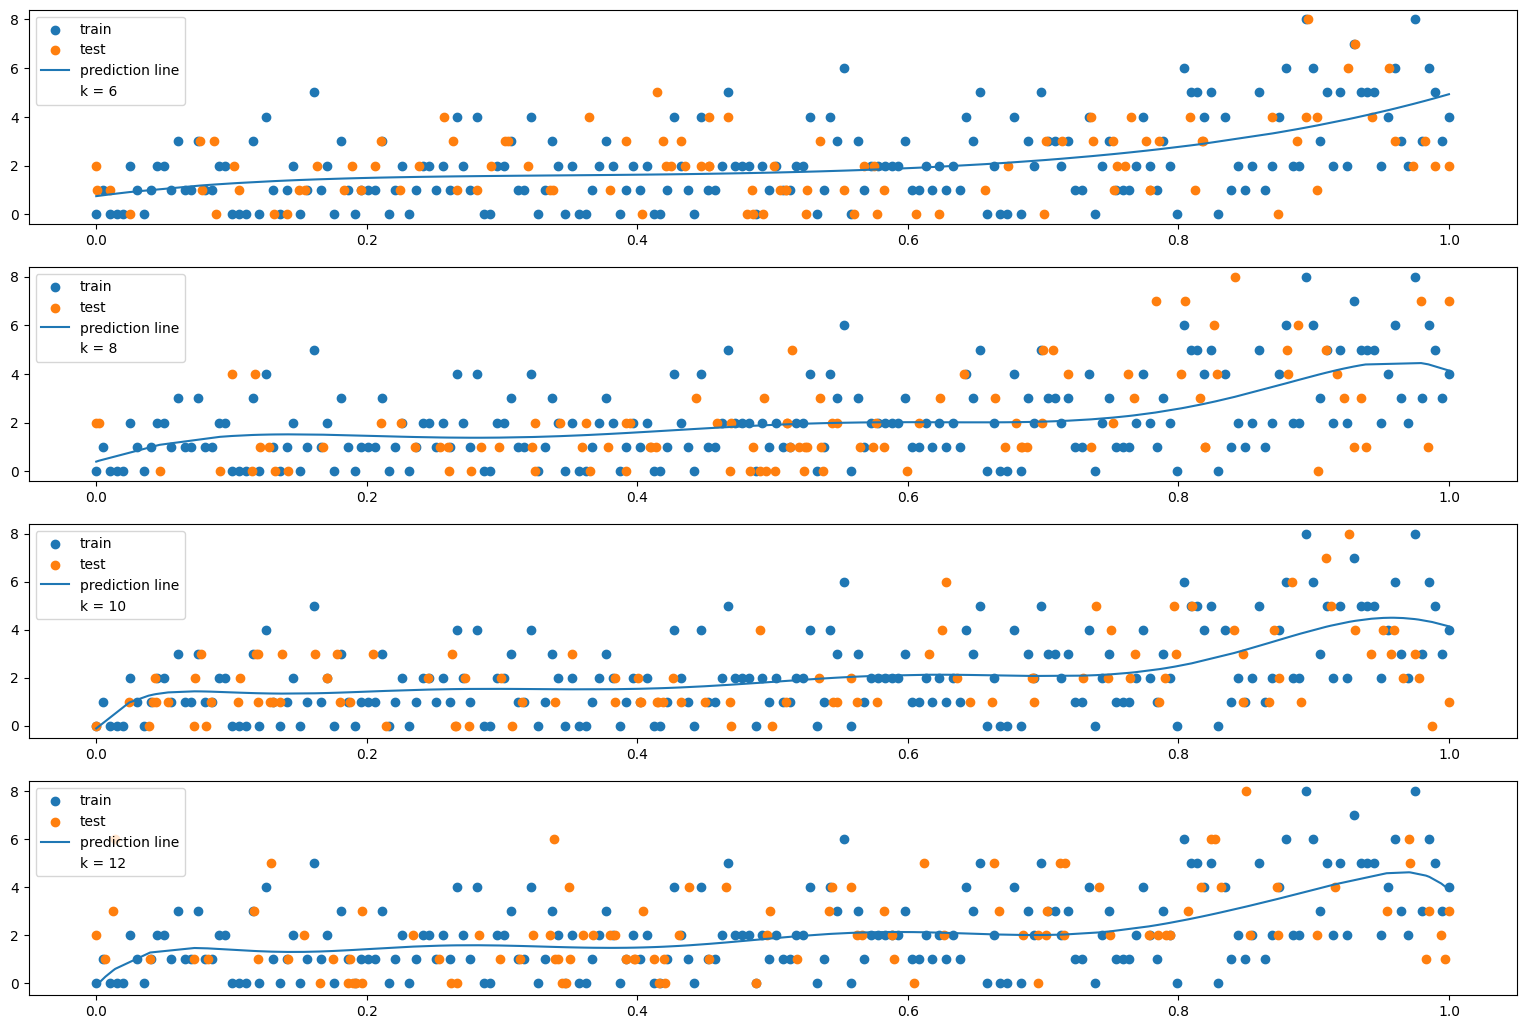

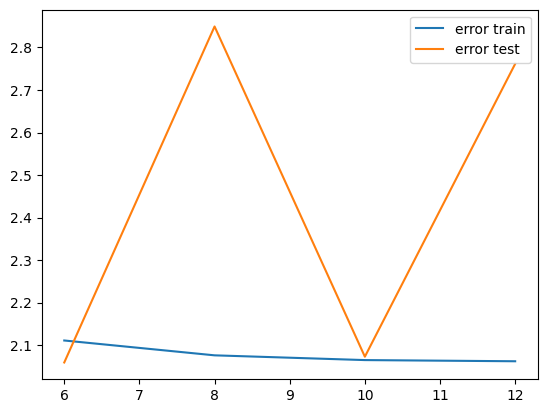

In [74]:
k_original = 4
N = 200
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
Y = np.random.poisson((v @ Theta_true)) 
acc_test = []
acc_train = []
ks = []
fig, axs = plt.subplots(4, figsize=(19.2,12.8))
j = 0
for k in [6, 8, 10, 12]:
    mle = MLE((X, Y), k)

    Xtest = np.random.default_rng().uniform(a, b, int(N/2))
    Xtest.sort()
    Xtest = np.concatenate(([a],Xtest, [b])) 
    vtest = vandermonde(Xtest, k_original)
    Ytest = np.random.poisson((vtest @ Theta_true)) 

    axs[j].scatter(X, Y, label = "train")
    axs[j].scatter(Xtest, Ytest, label = "test")
    f_value = f(mle, vandermonde(Xtest,k))
    acc_test.append(accuracy(mle, (vandermonde(Xtest, k), Ytest)))
    acc_train.append(accuracy(mle, (vandermonde(X, k), Y)))
    ks.append(k)
    axs[j].plot(Xtest, f_value, label = "prediction line")
    axs[j].plot([], [], ' ', label=f"k = {k}")
    axs[j].legend()
    j += 1
plt.show()

plt.plot(ks,acc_train, label = "error train")
plt.plot(ks,acc_test, label = "error test")
plt.legend()
plt.show()

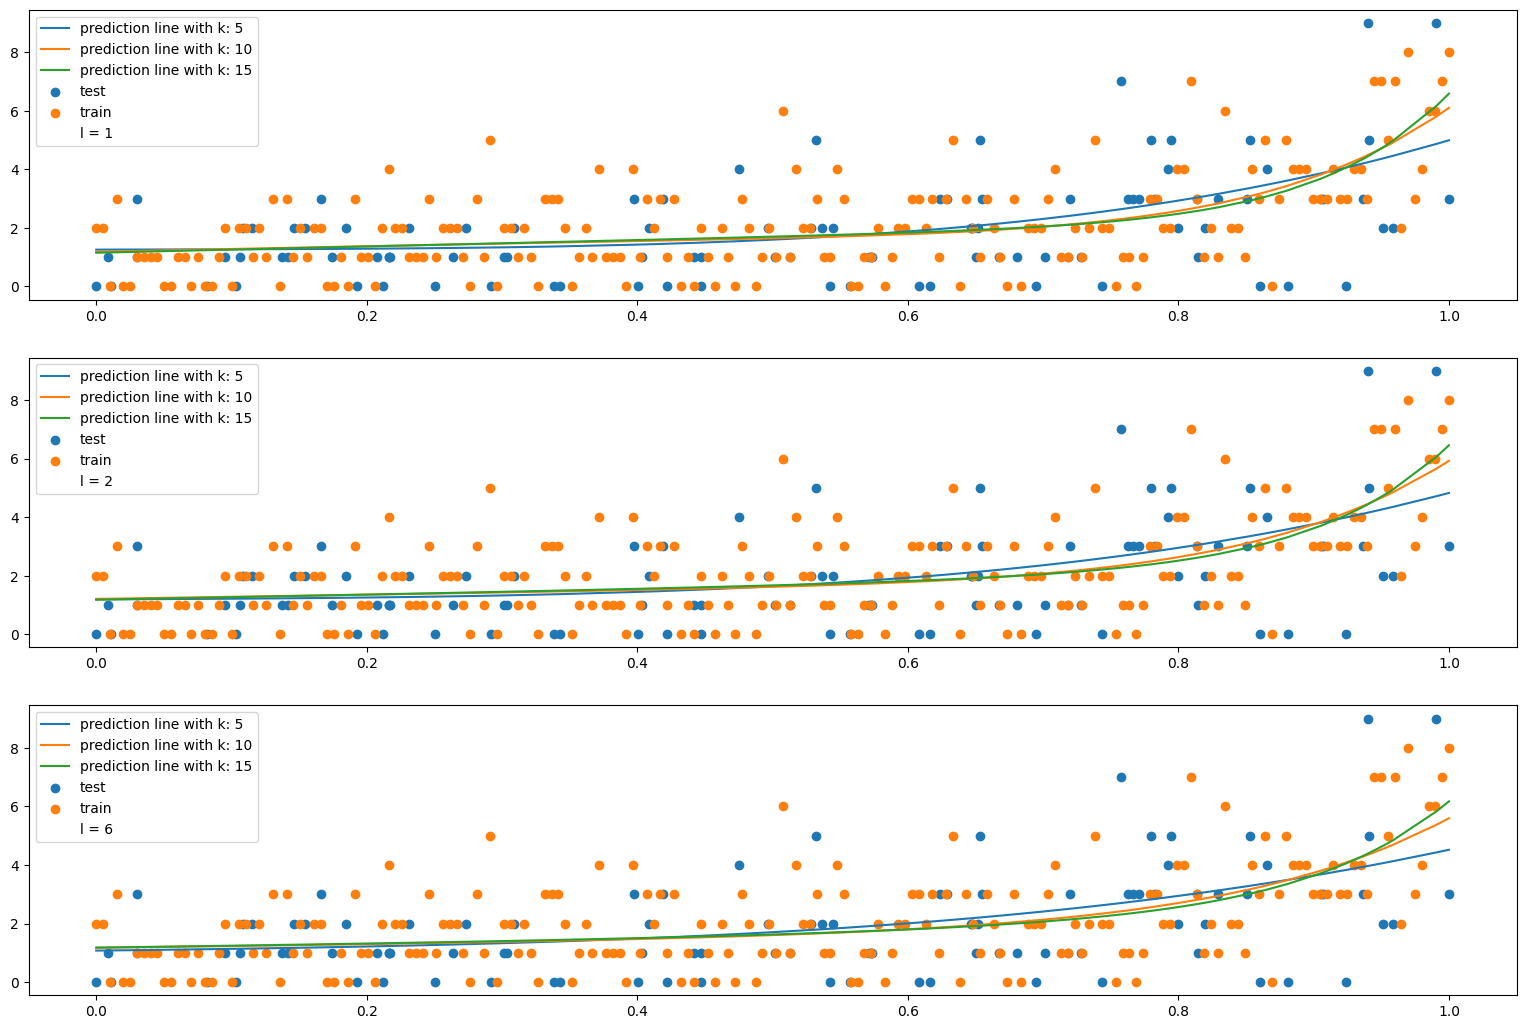

In [86]:
k_original = 4
N = 200
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
Y = np.random.poisson((v @ Theta_true)) 

Xtest = np.random.default_rng().uniform(a, b, int(N/2))
Xtest.sort()
Xtest = np.concatenate(([a],Xtest, [b])) 
vtest = vandermonde(Xtest, k_original)
Ytest = np.random.poisson((vtest @ Theta_true)) 

fig, axs = plt.subplots(3, figsize=(19.2,12.8))
j = 0
for l in [1, 2, 6]:
    for k_map in [5,10,15]:
        map = MAP((X,Y), k_map, l)
        f_value = f(map, vandermonde(Xtest,k_map))
        axs[j].plot(Xtest, f_value, label = f"prediction line with k: {k_map}")
    axs[j].scatter(Xtest, Ytest, label = "test")
    axs[j].scatter(X, Y, label = "train")
    axs[j].plot([], [], ' ', label=f"l = {l}")
    axs[j].legend()
    j += 1
plt.show()

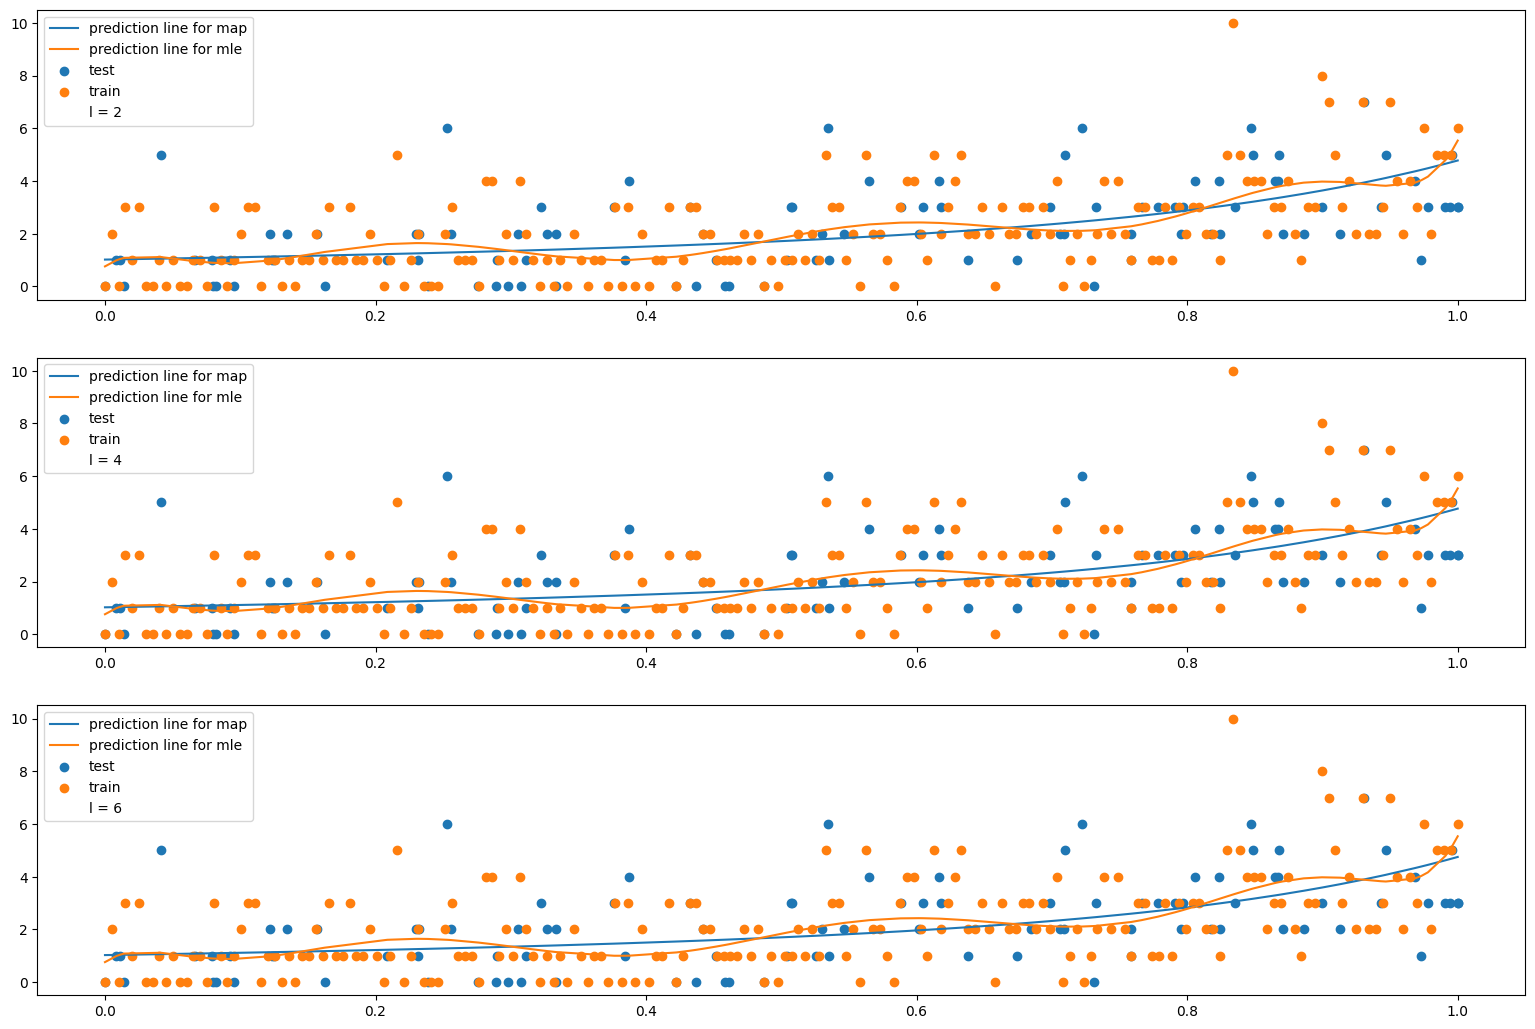

In [87]:
k_original = 4
N = 200
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
Y = np.random.poisson((v @ Theta_true)) 

Xtest = np.random.default_rng().uniform(a, b, int(N/2))
Xtest.sort()
Xtest = np.concatenate(([a],Xtest, [b])) 
vtest = vandermonde(Xtest, k_original)
Ytest = np.random.poisson((vtest @ Theta_true)) 

k_all = 10
mle = MLE((X, Y), k_all)
f_value_mle = f(mle, vandermonde(Xtest,k_all))
fig, axs = plt.subplots(3, figsize=(19.2,12.8))
j = 0
for l in [2,4,6]:
    map = MAP((X,Y), k_all, l)
    f_value_map = f(map, vandermonde(Xtest,k_all))
    axs[j].plot(Xtest, f_value_map, label = f"prediction line for map")
    axs[j].plot(Xtest, f_value_mle, label = f"prediction line for mle")
    axs[j].scatter(Xtest, Ytest, label = "test")
    axs[j].scatter(X, Y, label = "train")
    axs[j].plot([], [], ' ', label=f"l = {l}")
    axs[j].legend()
    j += 1
plt.show()

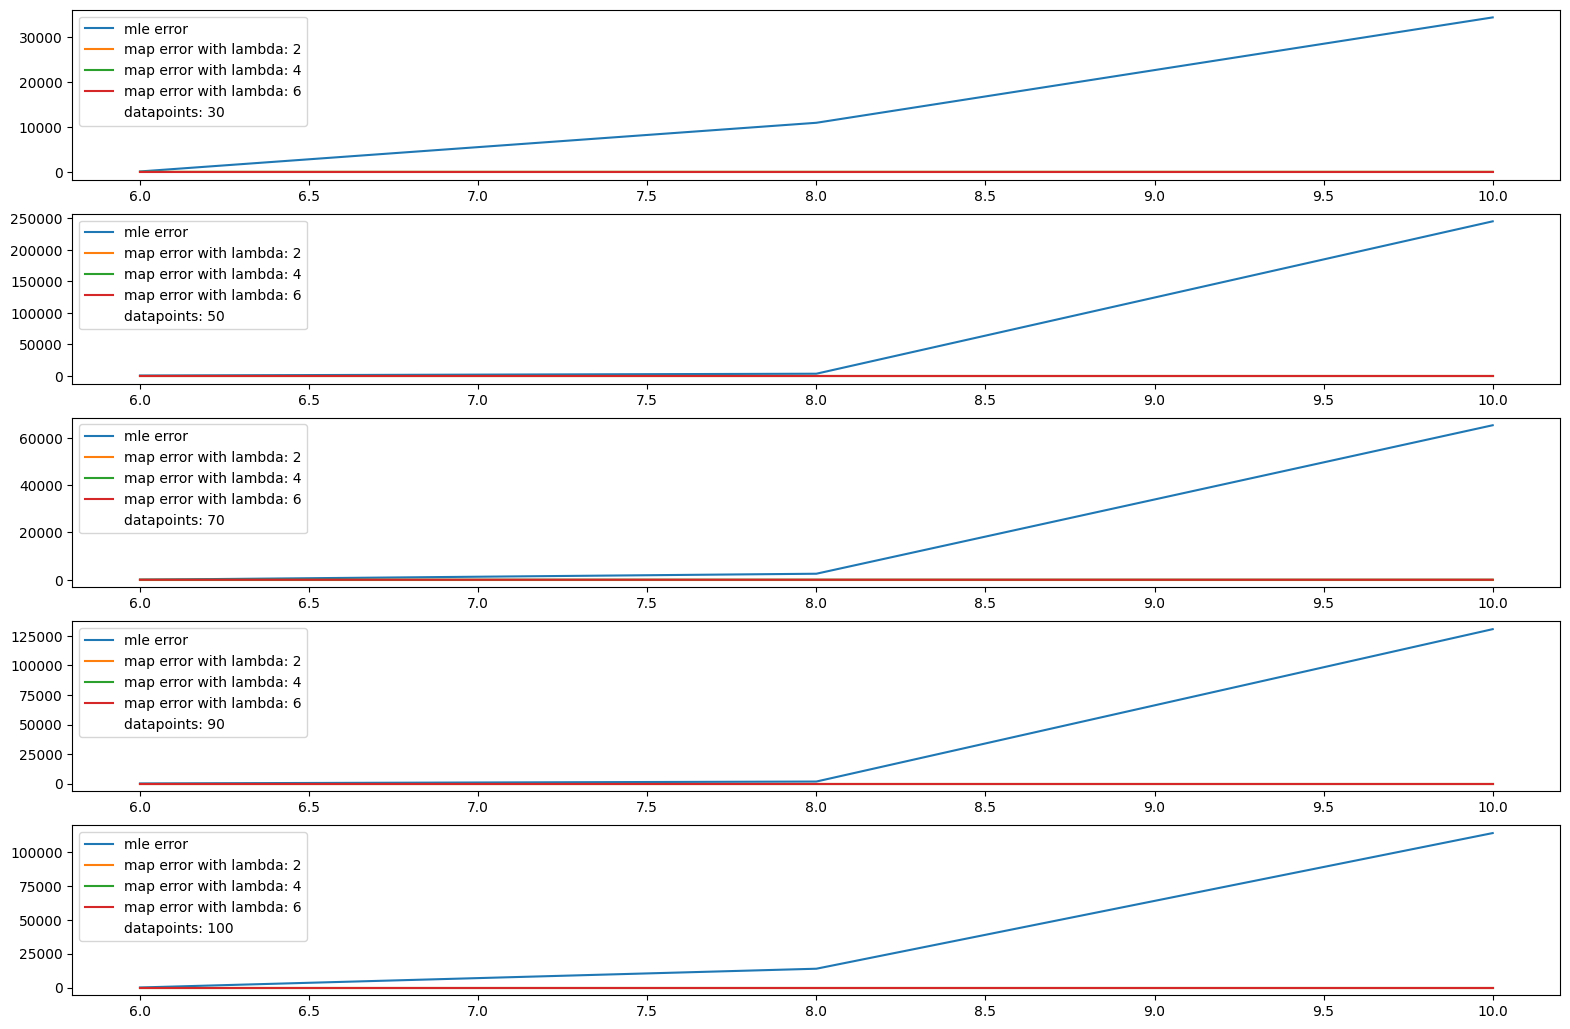

In [93]:
fig, axs = plt.subplots(5, figsize=(19.2,12.8))
j = 0
for N in [30, 50, 70, 90, 100]:
    k_original = 4
    Theta_true = np.ones((k_original,1))
    variance_original = 0.4
    variance = variance_original
    X = np.linspace(a,b, N)
    v = vandermonde(X, k_original)
    Y = np.random.poisson((v @ Theta_true)) 

    Xtest = np.random.default_rng().uniform(a, b, int(N/2))
    Xtest.sort()
    Xtest = np.concatenate(([a],Xtest, [b])) 
    vtest = vandermonde(Xtest, k_original)
    etest = np.random.normal(0,variance, (int(N/2) + 2,1))
    Ytest = np.random.poisson((vtest @ Theta_true)) 

    def errorCompute(theta, theta_true):
        return np.linalg.norm(theta - theta_true, 2) / np.linalg.norm(theta_true, 2)

    mle_err = []
    map_err = {2: [], 4: [], 6: []}
    for k_all in [6,8,10]:
        theta_true_k = np.concatenate((Theta_true, np.zeros((k_all - k_original, 1))))
        mle = MLE((X, Y), k_all)
        error_mle = errorCompute(mle, theta_true_k)
        mle_err.append(error_mle)
        for l in [2, 4, 6]:
            map = MAP((X,Y), k_all, l)
            error_map = errorCompute(map, theta_true_k)
            map_err[l].append(error_map)

    axs[j].plot([6,8,10], mle_err, label = f"mle error")
    for el in map_err:
        axs[j].plot([6,8,10], map_err[el], label = f"map error with lambda: {el}")
    axs[j].plot([], [], ' ', label=f"datapoints: {N}")
    axs[j].legend()
    j += 1
plt.show()

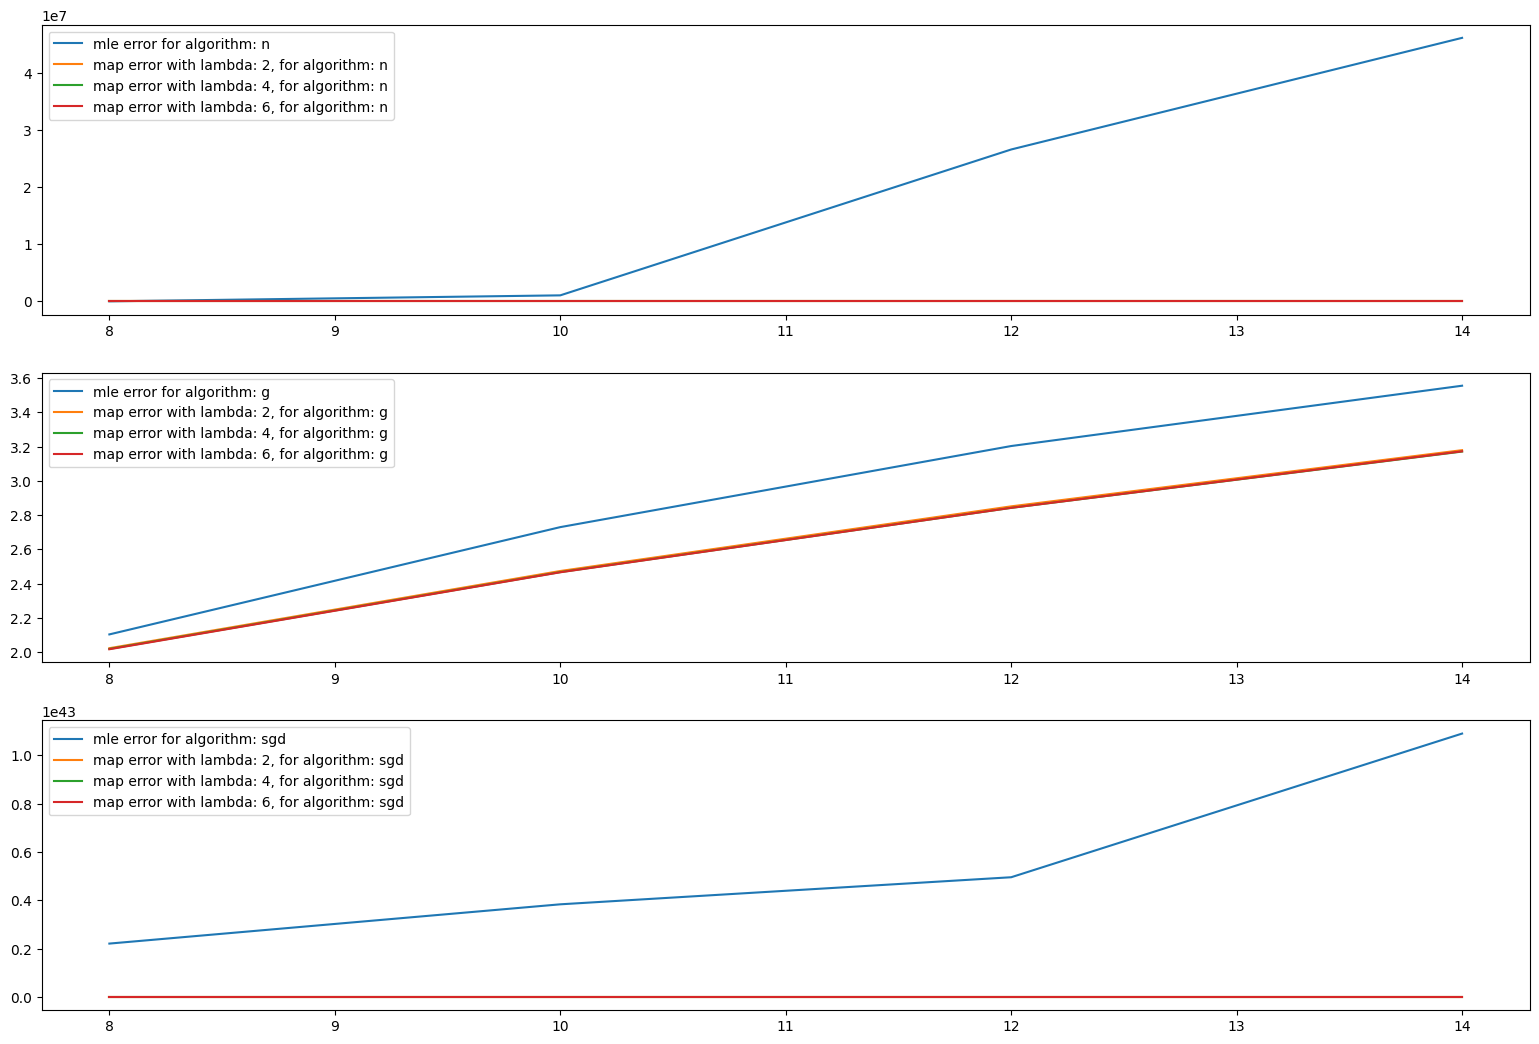

In [62]:
N = 200
k_original = 4
Theta_true = np.ones((k_original,1))
variance_original = 0.4
variance = variance_original
X = np.linspace(a,b, N)
v = vandermonde(X, k_original)
Y = np.random.poisson((v @ Theta_true)) 
Y = np.reshape(Y, (N,))
Xtest = np.random.default_rng().uniform(a, b, int(N/2))
Xtest.sort()
Xtest = np.concatenate(([a],Xtest, [b])) 
vtest = vandermonde(Xtest, k_original)
Ytest = np.random.poisson((vtest @ Theta_true)) 
def errorCompute(theta, theta_true):
    return np.linalg.norm(theta - theta_true, 2) / np.linalg.norm(theta_true, 2)

fig, axs = plt.subplots(3, figsize=(19.2,12.8))
j = 0
mle_err = {"n": [], "g": [], "sgd": []}
map_err = {"n": {2: [], 4: [], 6: []}, "g": {2: [], 4: [], 6: []}, "sgd": {2: [], 4: [], 6: []}}
for alg in ["n", "g", "sgd"]:
    for k_all in [8,10,12,14]:
        theta_true_k = np.concatenate((Theta_true, np.zeros((k_all - k_original, 1))))
        mle = MLE((X, Y), k_all, alg)
        error_mle = errorCompute(mle, theta_true_k)
        mle_err[alg].append(error_mle)
        for l in [2, 4, 6]:
            map = MAP((X,Y), k_all, l, alg)
            error_map = errorCompute(map, theta_true_k)
            map_err[alg][l].append(error_map)
    axs[j].plot([8,10,12,14], mle_err[alg], label = f"mle error for algorithm: {alg}")
    for el in map_err["n"]:
        axs[j].plot([8,10,12,14], map_err[alg][el], label = f"map error with lambda: {el}, for algorithm: {alg}")
    axs[j].legend()
    j += 1
plt.show()